In [1]:
import pandas as pd
import os
import re
import numpy as np
import sys
pd.options.mode.chained_assignment = None  # default='warn'
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import scipy
import statsmodels.api as sm
import statsmodels.stats.proportion as prop
import pickle

/Users/davidbailey/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/davidbailey/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return (h)

colors={'lightgrey':'#bcc4cd',
        'darkgrey':'#566573',
       'myorange':'#e95c25',
       'myblue':'#4392f1',
       'mygreen':'#00a878'}

In [5]:
#users = pd.read_csv('../data/users_ratings.csv')
users = pd.read_csv('data/users_ratings.csv')
users = users.set_index('userid')

In [6]:
# Get users w/ at least 5 written tweets
u = users[users['orig_total_count']>=5]

In [7]:
#u[['orig_rating']].dropna().to_csv('../data/users_orig_rating.csv')

In [8]:
#u.to_csv('../data/users_orig_rating.csv')

In [9]:
# Retweet network 
#rt = pd.read_csv('../data/rt_network.csv')
rt = pd.read_csv('data/rt_network.csv')

In [10]:
print('Total users: ' + str(len(users)))
print('Total edges: ' + str(len(rt)))
print('Total retweets: ' + str(rt['rt'].sum()))

print('Users on the right: ' + str(len(users[users['orig_rating']>0])))
#print('Edges between the users on the right: ' + str(len(r_r)))
#print('Total retweets on the right: ' + str(r_r['rt'].sum()))

print('Users on the left: ' + str(len(users[users['orig_rating']<0])))
#print('Edges between the users on the left: ' + str(len(r)))
#print('Total retweets on the left: ' + str(r['rt'].sum()))

Total users: 1865559
Total edges: 107562040
Total retweets: 262410320
Users on the right: 147434
Users on the left: 274437


### Compare to the random baseline

We calculate the conditional probability of being connected to more extreme person. More precisely, we focus on the empirical expected value. It is hard to get the theoretical probability distribution and calculate the probabilities. The straight-forward way is to randomize the peers and compare with the empirical.

In [11]:
# Takes df r2 - calculates frac of unique ids - gets rows of r2 whose user ids are in calculated frac
# Gets random sample of egos (according to frac)
def get_random(r2, frac=1):
    us = r2['userid'].unique()
    us_sample = np.random.choice(us, size=int(len(us)*frac), replace=False)
    return(r2[r2['userid'].isin(us_sample)])

In [12]:
# Takes network df - creates subset of network df that fits stretegy - either max homophily or max one-sided homophily
def get_closest(r_,direction='any'): #direction can be any or right
    e = r_['orig_rating_ego'].values
    p = r_['orig_rating_peer'].values
    limit = 0.7
    closest=[]
    # create subset of r_ with max homophily participants for 70% of data - contains political affiliations
    if direction == 'any':
        for ev in e[0:int(len(e)*limit)]: # for 70% of egos
            absolute_val_array = np.abs(p - ev) # abs peer polit minus ego polit
            smallest_difference_index = absolute_val_array.argmin()
            closest_element = p[smallest_difference_index]
            p = np.delete(p,smallest_difference_index)
            closest.append(closest_element)
        r_ = r_.iloc[0:len(closest)] # only participants in closest
        r_['orig_rating_peer'] = closest
    if direction == 'right':
        for ev in e[0:int(len(e)*limit)]:
            diff = p - ev
            smallest_difference_index = np.where(diff >= 0, diff, diff**2 + 100).argmin() # this is like ifelse
            closest_element = p[smallest_difference_index]
            p = np.delete(p,smallest_difference_index)
            closest.append(closest_element)
        r_ = r_.iloc[0:len(closest)]
        r_['orig_rating_peer'] = closest
    return(r_)

In [13]:
# ??? - maybe getting participants furthest from ego
def get_furthest(r_):
    e = r_['orig_rating_ego'].values
    p = r_['orig_rating_peer'].values
    diff = p - e
    pos_diff = [x for x in diff if x >= 0]
    r_ = r_.iloc[0:len(pos_diff)]
    r_['orig_rating_peer'] = s[0:len(pos_diff)]
    return(r_)

In [14]:
# Runs subsetting 
def baseline_biased(r_,furthest=False,direction='any'):
    if furthest == True:
        r_ = get_furthest(r_)
    else:
        r_ = get_closest(r_,direction)
    return(r_)

In [15]:
# Gets a random sample of peers
def baseline_rand(r_,sim_limit):
    r_short = r_.iloc[:int((len(r_)*sim_limit))]
    r_short['orig_rating_ego'] = r_['orig_rating_ego'].sample(frac=1).iloc[:int((len(r_)*sim_limit))].values
    r_short['orig_rating_peer'] = r_['orig_rating_peer'].sample(frac=1).iloc[:int((len(r_)*sim_limit))].values
    return(r_short)

In [16]:
def get_base_ratings(r,u,thresh=5,baseline='rand'): #baseline = ['rand','homo','acro','homo_right']
    r1 = r[r['rt']>=thresh]
    r2 = r1.join(u[['orig_rating']],on='userid').join(u[['orig_rating']],on='rt_userid',rsuffix = '_peer').rename(columns={'orig_rating':'orig_rating_ego'})
    if baseline == 'rand':
        #r2['orig_rating_peer'] = r2['orig_rating_peer'].sample(frac=1).values
        r2 = baseline_rand(r2,0.7)
    if baseline == 'homo':
        r2 = baseline_biased(r2.sample(frac=1),furthest=False)
    if baseline == 'acro': # does this matter? - maybe not
        r2 = baseline_biased(get_random(r2, .1),furthest=True)
    if baseline == 'homo_right':    
        r2 = baseline_biased(r2.sample(frac=1),direction='right')
        
    ego_rating = r2.groupby('userid')['orig_rating_ego'].mean()
    peer_rating = r2.groupby('userid')['orig_rating_peer'].mean()
    s = r2.drop_duplicates(subset=['userid'])[['userid','orig_rating_ego']].set_index('userid')
    s = s.join(r2.groupby('userid')['orig_rating_peer'].mean())
    h = len(s[s['orig_rating_ego']<s['orig_rating_peer']])
    peer_prob_higher = h/(len(s))
    peer_prob_higher_ci = peer_prob_higher - prop.proportion_confint(h, len(s), alpha=0.05, method='normal')[0]
    return(ego_rating,peer_rating,peer_prob_higher,peer_prob_higher_ci)

In [17]:
def repeat_base_rating(r,u,baseline,direction='any',thresh=5,n=5):
    ego_rating = pd.Series(dtype = 'float64')
    peer_rating = pd.Series(dtype = 'float64')
    peer_prob_higher = []
    peer_prob_higher_ci = []
    for i in range(0,n):
        print(i)
        eb,pb,pphb,pphc = get_base_ratings(r,u,thresh=thresh,baseline=baseline)
        ego_rating = pd.concat([ego_rating, eb])
        peer_rating = pd.concat([peer_rating, pb])
        peer_prob_higher.append(pphb)
        peer_prob_higher_ci.append(pphc)
    return(ego_rating,peer_rating,np.mean(peer_prob_higher),np.mean(peer_prob_higher_ci))

In [18]:
orient = 'right'
min_tweets = 5

if orient == 'right':
    u = users[users['orig_rating']>0]

u = u[u['orig_total_count']>=min_tweets]
    
r_r = rt[rt['userid'].isin(u.index) & rt['rt_userid'].isin(u.index)]
#r_r = r_r.sample(frac=0.2)

In [19]:
# r = r_r.copy()
# thresh = 5
# r1 = r[r['rt']>=thresh]
# r2 = r1.join(u[['orig_rating']],on='userid').join(u[['orig_rating']],on='rt_userid',rsuffix = '_peer').rename(columns={'orig_rating':'orig_rating_ego'})
# r2['orig_rating_peer'] = r2['orig_rating_peer'].sample(frac=1).values


In [20]:
baseline = {
    'rand':{},
    'homo':{},
    'homo_right':{},
    'empi':{}
}

In [21]:
range_start = 3
range_end = 35
for thresh in range(range_start,range_end, 3):
    print(thresh)
    models = ['rand','homo','homo_right','empi']
    for b in models:
        print(b)
        if b == 'homo':
            ego,peer,peer_higher, peer_higher_ci = repeat_base_rating(r_r,u,thresh=thresh,baseline='homo',n=5)
        if b == 'homo_right':
            ego,peer,peer_higher, peer_higher_ci = repeat_base_rating(r_r,u,thresh=thresh,baseline='homo_right',n=5)
        else:
            ego,peer,peer_higher, peer_higher_ci = get_base_ratings(r_r,u,thresh=thresh,baseline=b)
        baseline[b][thresh] = {'ego':ego.mean(), 'ego_ci':mean_confidence_interval(ego),
                                      'peer':peer.mean(),'peer_ci':mean_confidence_interval(peer),
                                      'peer_prob_higher':peer_higher, 'peer_prob_ci':peer_higher_ci}
        
#with open('../data/baseline_right_'+str(range_start)+'_'+str(range_end)+'_.pickle', 'wb') as handle:
#    pickle.dump(baseline, handle, protocol=pickle.HIGHEST_PROTOCOL)

3
rand
homo
0
1
2
3
4
homo_right
0
1
2
3
4
empi
6
rand
homo
0
1
2
3
4
homo_right
0
1
2
3
4
empi
9
rand
homo
0
1
2
3
4
homo_right
0
1
2
3
4
empi
12
rand
homo
0
1
2
3
4
homo_right
0
1
2
3
4
empi
15
rand
homo
0
1
2
3
4
homo_right
0
1
2
3
4
empi
18
rand
homo
0
1
2
3
4
homo_right
0
1
2
3
4
empi
21
rand
homo
0
1
2
3
4
homo_right
0
1
2
3
4
empi
24
rand
homo
0
1
2
3
4
homo_right
0
1
2
3
4
empi
27
rand
homo
0
1
2
3
4
homo_right
0
1
2
3
4
empi
30
rand
homo
0
1
2
3
4
homo_right
0
1
2
3
4
empi
33
rand
homo
0
1
2
3
4
homo_right
0
1
2
3
4
empi


In [22]:
x = []
egos = []
peer_base = []
peer_base_h = []
peer_base_a = []
peer_empi = []

egos_ci = []
peer_base_ci = []
peer_base_h_ci = []
peer_base_a_ci = []
peer_empi_ci = []

pphb = []
pphbh = []
pphba = []
pph = []

pphb_ci = []
pphbh_ci = []
pphba_ci = []
pph_ci = []

for k,v in baseline['rand'].items():
    x.append(k)
    egos.append(v['ego'])
    egos_ci.append(v['ego_ci'])
 
    peer_base.append(v['peer'])
    peer_base_ci.append(v['peer_ci'])
    pphb.append(v['peer_prob_higher'])
    pphb_ci.append(v['peer_prob_ci'])

for k,v in baseline['homo'].items():
    peer_base_h.append(v['peer'])
    peer_base_h_ci.append(v['peer_ci'])
    pphbh.append(v['peer_prob_higher'])
    pphbh_ci.append(v['peer_prob_ci'])
    
for k,v in baseline['homo_right'].items():
    peer_base_a.append(v['peer'])
    peer_base_a_ci.append(v['peer_ci'])
    pphba.append(v['peer_prob_higher'])
    pphba_ci.append(v['peer_prob_ci'])
    
for k,v in baseline['empi'].items():
    peer_empi.append(v['peer'])
    peer_empi_ci.append(v['peer_ci'])
    pph.append(v['peer_prob_higher'])
    pph_ci.append(v['peer_prob_ci'])

In [24]:
pd.DataFrame(list(zip(x, peer_base, peer_base_ci, peer_base_h, peer_base_h_ci,peer_base_a,peer_base_a_ci,peer_empi,peer_empi_ci)), 
               columns =['x', 'baseline', 'baseline_ci','homophily','homophily_ci','homophily_right','homophily_right_ci','empirical','empirical_ci']).to_csv('data/leaning.csv',index=False)

pd.DataFrame(list(zip(x, pphb, pphb_ci,pphbh,pphbh_ci,pphba,pphba_ci,pph,pph_ci)), 
               columns =['x', 'baseline', 'baseline_ci', 'homophily', 'homophily_ci', 'homophily_right', 'homophily_right_ci','empirical','empirical_ci']).to_csv('data/probability.csv',index=False)

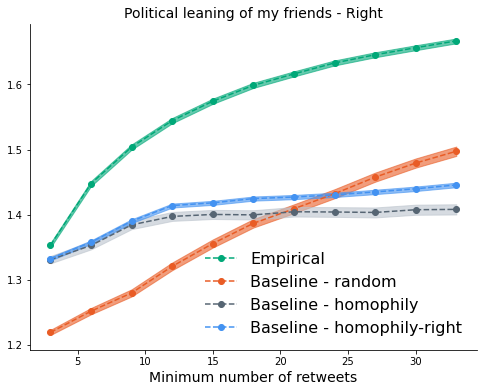

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))
#ax.plot(x, egos,  '--o', label='Ego', color=colors['myblue'])
#ax.fill_between(x, np.subtract(egos,egos_ci), np.add(egos,egos_ci), color=colors['myblue'], alpha=0.6)

ax.plot(x, peer_empi,  '--o', label='Empirical', color = colors['mygreen'])
ax.fill_between(x, np.subtract(peer_empi,peer_empi_ci), np.add(peer_empi,peer_empi_ci), color=colors['mygreen'], alpha=0.6)

ax.plot(x, peer_base,  '--o', label='Baseline - random', color = colors['myorange'])
ax.fill_between(x, np.subtract(peer_base,peer_base_ci), np.add(peer_base,peer_base_ci), color=colors['myorange'], alpha=0.6)

ax.plot(x, peer_base_h,  '--o', label='Baseline - homophily', color = colors['darkgrey'])
ax.fill_between(x, np.subtract(peer_base_h,peer_base_h_ci), np.add(peer_base_h,peer_base_h_ci), color=colors['lightgrey'], alpha=0.6)

ax.plot(x, peer_base_a,  '--o', label='Baseline - homophily-right', color = colors['myblue'])
ax.fill_between(x, np.subtract(peer_base_a,peer_base_a_ci), np.add(peer_base_a,peer_base_a_ci), color=colors['myblue'], alpha=0.6)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Political leaning of my friends - Right', fontsize=14)
ax.set_xlabel('Minimum number of retweets', fontsize=14)
ax.legend(fontsize=16,frameon=False)

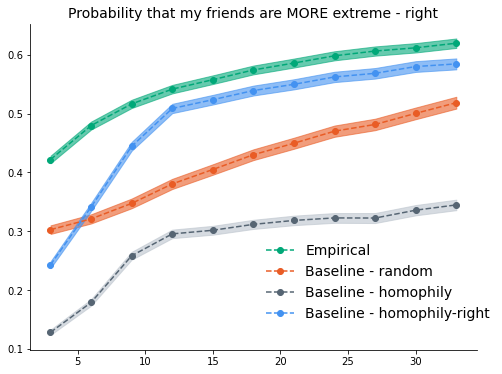

In [26]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, pph,  '--o', label='Empirical', color=colors['mygreen'])
ax.fill_between(x, np.subtract(pph,pph_ci), np.add(pph,pph_ci), color=colors['mygreen'], alpha=0.6)

ax.plot(x, pphb,  '--o', label='Baseline - random', color=colors['myorange'])
ax.fill_between(x, np.subtract(pphb,pphb_ci), np.add(pphb,pphb_ci), color=colors['myorange'], alpha=0.6)

ax.plot(x, pphbh,  '--o', label='Baseline - homophily', color=colors['darkgrey'])
ax.fill_between(x, np.subtract(pphbh,pphbh_ci), np.add(pphbh,pphbh_ci), color=colors['lightgrey'], alpha=0.6)

ax.plot(x, pphba,  '--o', label='Baseline - homophily-right', color=colors['myblue'])
ax.fill_between(x, np.subtract(pphba,pphba_ci), np.add(pphba,pphba_ci), color=colors['myblue'], alpha=0.6)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_title('Probability that my friends are MORE extreme - right', fontsize=14)

ax.legend(loc= 'lower left',fontsize=14, bbox_to_anchor=(0.5, 0.05), bbox_transform=ax.transAxes, frameon=False)


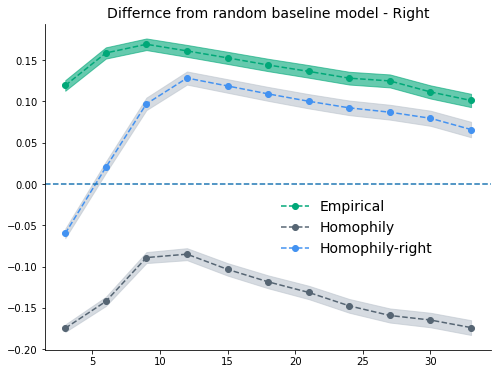

In [27]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, np.array(pph) - np.array(pphb),  '--o', label='Empirical', color=colors['mygreen'])
ax.fill_between(x, np.subtract(np.array(pph) - np.array(pphb),pph_ci), np.add(np.array(pph) - np.array(pphb),pph_ci), color=colors['mygreen'], alpha=0.6)

ax.plot(x, np.array(pphbh) - np.array(pphb),  '--o', label='Homophily', color=colors['darkgrey'])
ax.fill_between(x, np.subtract(np.array(pphbh) - np.array(pphb),pphbh_ci), np.add(np.array(pphbh) - np.array(pphb),pphbh_ci), color=colors['lightgrey'], alpha=0.6)

ax.plot(x, np.array(pphba) - np.array(pphb),  '--o', label='Homophily-right', color=colors['myblue'])
ax.fill_between(x, np.subtract(np.array(pphba) - np.array(pphb),pphba_ci), np.add(np.array(pphba) - np.array(pphb),pphba_ci), color=colors['lightgrey'], alpha=0.6)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_title('Differnce from random baseline model - Right', fontsize=14)
ax.axhline(y=0, linestyle='dashed')
ax.legend(loc= 'lower left',fontsize=14, bbox_to_anchor=(0.5, 0.25), bbox_transform=ax.transAxes, frameon=False)

#### Plot

In [28]:
orient = 'left'
min_tweets = 5

if orient == 'left':
    u = users[users['orig_rating']<0]
    u['orig_rating'] = u['orig_rating'] * -1
    
u = u[u['orig_total_count']>=min_tweets]
    
r = rt[rt['userid'].isin(u.index) & rt['rt_userid'].isin(u.index)]

In [29]:
baseline_left = {
    'rand':{},
    'homo':{},
    'homo_right':{},
    'empi':{}
}

In [30]:
range_start = 3
range_end = 35
for thresh in range(range_start,range_end,3):
    print(thresh)
    models = ['rand','homo','homo_right','empi']
    for b in models:
        print(b)
        if b == 'homo':
            ego,peer,peer_higher, peer_higher_ci = repeat_base_rating(r,u,thresh=thresh,baseline='homo',n=5)
        if b == 'homo_right':
            ego,peer,peer_higher, peer_higher_ci = repeat_base_rating(r,u,thresh=thresh,baseline='homo_right',n=5)
        else:
            ego,peer,peer_higher, peer_higher_ci = get_base_ratings(r,u,thresh=thresh,baseline=b)
        baseline_left[b][thresh] = {'ego':ego.mean(), 'ego_ci':mean_confidence_interval(ego),
                                      'peer':peer.mean(),'peer_ci':mean_confidence_interval(peer),
                                      'peer_prob_higher':peer_higher, 'peer_prob_ci':peer_higher_ci}
        
#with open('../data/baseline_left_'+str(range_start)+'_'+str(range_end)+'_.pickle', 'wb') as handle:
#    pickle.dump(baseline_left, handle, protocol=pickle.HIGHEST_PROTOCOL)

3
rand
homo
0
1
2
3
4
homo_right
0
1
2
3
4
empi
6
rand
homo
0
1
2
3
4
homo_right
0
1
2
3
4
empi
9
rand
homo
0
1
2
3
4
homo_right
0
1
2
3
4
empi
12
rand
homo
0
1
2
3
4
homo_right
0
1
2
3
4
empi
15
rand
homo
0
1
2
3
4
homo_right
0
1
2
3
4
empi
18
rand
homo
0
1
2
3
4
homo_right
0
1
2
3
4
empi
21
rand
homo
0
1
2
3
4
homo_right
0
1
2
3
4
empi
24
rand
homo
0
1
2
3
4
homo_right
0
1
2
3
4
empi
27
rand
homo
0
1
2
3
4
homo_right
0
1
2
3
4
empi
30
rand
homo
0
1
2
3
4
homo_right
0
1
2
3
4
empi
33
rand
homo
0
1
2
3
4
homo_right
0
1
2
3
4
empi


In [31]:
x = []
egos = []
peer_base = []
peer_base_h = []
peer_base_a = []
peer_empi = []

egos_ci = []
peer_base_ci = []
peer_base_h_ci = []
peer_base_a_ci = []
peer_empi_ci = []

pphb = []
pphbh = []
pphba = []
pph = []

pphb_ci = []
pphbh_ci = []
pphba_ci = []
pph_ci = []

for k,v in baseline_left['rand'].items():
    x.append(k)
    egos.append(v['ego'])
    egos_ci.append(v['ego_ci'])
 
    peer_base.append(v['peer'])
    peer_base_ci.append(v['peer_ci'])
    pphb.append(v['peer_prob_higher'])
    pphb_ci.append(v['peer_prob_ci'])

for k,v in baseline_left['homo'].items():
    peer_base_h.append(v['peer'])
    peer_base_h_ci.append(v['peer_ci'])
    pphbh.append(v['peer_prob_higher'])
    pphbh_ci.append(v['peer_prob_ci'])
    
for k,v in baseline_left['homo_right'].items():
    peer_base_a.append(v['peer'])
    peer_base_a_ci.append(v['peer_ci'])
    pphba.append(v['peer_prob_higher'])
    pphba_ci.append(v['peer_prob_ci'])
    
for k,v in baseline_left['empi'].items():
    peer_empi.append(v['peer'])
    peer_empi_ci.append(v['peer_ci'])
    pph.append(v['peer_prob_higher'])
    pph_ci.append(v['peer_prob_ci'])

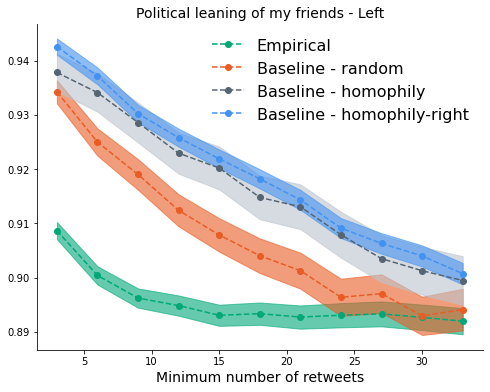

In [32]:
fig, ax = plt.subplots(figsize=(8, 6))
#ax.plot(x, egos,  '--o', label='Ego', color=colors['myblue'])
#ax.fill_between(x, np.subtract(egos,egos_ci), np.add(egos,egos_ci), color=colors['myblue'], alpha=0.6)

ax.plot(x, peer_empi,  '--o', label='Empirical', color = colors['mygreen'])
ax.fill_between(x, np.subtract(peer_empi,peer_empi_ci), np.add(peer_empi,peer_empi_ci), color=colors['mygreen'], alpha=0.6)

ax.plot(x, peer_base,  '--o', label='Baseline - random', color = colors['myorange'])
ax.fill_between(x, np.subtract(peer_base,peer_base_ci), np.add(peer_base,peer_base_ci), color=colors['myorange'], alpha=0.6)

ax.plot(x, peer_base_h,  '--o', label='Baseline - homophily', color = colors['darkgrey'])
ax.fill_between(x, np.subtract(peer_base_h,peer_base_h_ci), np.add(peer_base_h,peer_base_h_ci), color=colors['lightgrey'], alpha=0.6)

ax.plot(x, peer_base_a,  '--o', label='Baseline - homophily-right', color = colors['myblue'])
ax.fill_between(x, np.subtract(peer_base_a,peer_base_a_ci), np.add(peer_base_a,peer_base_a_ci), color=colors['myblue'], alpha=0.6)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Political leaning of my friends - Left', fontsize=14)
ax.set_xlabel('Minimum number of retweets', fontsize=14)
ax.legend(fontsize=16, frameon=False)

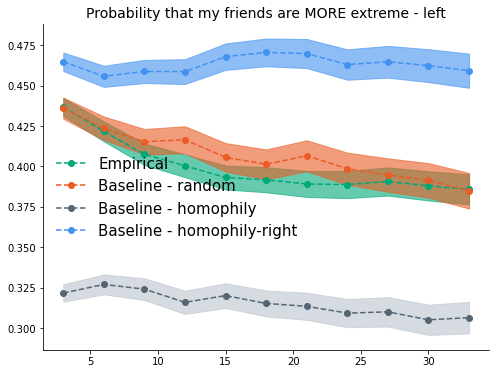

In [33]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, pph,  '--o', label='Empirical', color=colors['mygreen'])
ax.fill_between(x, np.subtract(pph,pph_ci), np.add(pph,pph_ci), color=colors['mygreen'], alpha=0.6)

ax.plot(x, pphb,  '--o', label='Baseline - random', color=colors['myorange'])
ax.fill_between(x, np.subtract(pphb,pphb_ci), np.add(pphb,pphb_ci), color=colors['myorange'], alpha=0.6)

ax.plot(x, pphbh,  '--o', label='Baseline - homophily', color=colors['darkgrey'])
ax.fill_between(x, np.subtract(pphbh,pphbh_ci), np.add(pphbh,pphbh_ci), color=colors['lightgrey'], alpha=0.6)

ax.plot(x, pphba,  '--o', label='Baseline - homophily-right', color=colors['myblue'])
ax.fill_between(x, np.subtract(pphba,pphba_ci), np.add(pphba,pphba_ci), color=colors['myblue'], alpha=0.6)

ax.set_title('Probability that my friends are MORE extreme - left', fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(loc= 'lower left', bbox_to_anchor=(0, 0.3), bbox_transform=ax.transAxes, fontsize=15, frameon=False)
#ax.legend(fontsize=14)


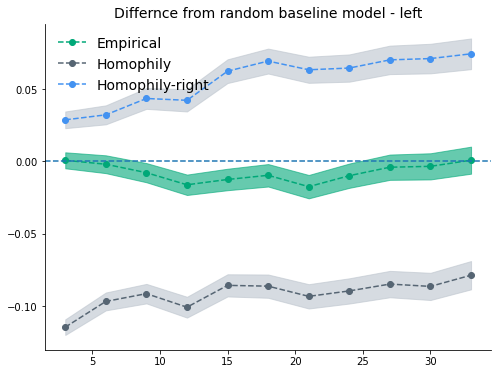

In [34]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, np.array(pph) - np.array(pphb),  '--o', label='Empirical', color=colors['mygreen'])
ax.fill_between(x, np.subtract(np.array(pph) - np.array(pphb),pph_ci), np.add(np.array(pph) - np.array(pphb),pph_ci), color=colors['mygreen'], alpha=0.6)

ax.plot(x, np.array(pphbh) - np.array(pphb),  '--o', label='Homophily', color=colors['darkgrey'])
ax.fill_between(x, np.subtract(np.array(pphbh) - np.array(pphb),pphbh_ci), np.add(np.array(pphbh) - np.array(pphb),pphbh_ci), color=colors['lightgrey'], alpha=0.6)

ax.plot(x, np.array(pphba) - np.array(pphb),  '--o', label='Homophily-right', color=colors['myblue'])
ax.fill_between(x, np.subtract(np.array(pphba) - np.array(pphb),pphba_ci), np.add(np.array(pphba) - np.array(pphb),pphba_ci), color=colors['lightgrey'], alpha=0.6)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_title('Differnce from random baseline model - left', fontsize=14)
ax.axhline(y=0, linestyle='dashed')
ax.legend(fontsize=14,frameon=False)

In [ ]:
pd.DataFrame(list(zip(x, peer_base, peer_base_ci, peer_base_h, peer_base_h_ci,peer_base_a,peer_base_a_ci,peer_empi,peer_empi_ci)), 
               columns =['x', 'baseline', 'baseline_ci','homophily','homophily_ci','homophily_right','homophily_right_ci','empirical','empirical_ci']).to_csv('../data/leaning_left.csv',index=False)

pd.DataFrame(list(zip(x, pphb, pphb_ci,pphbh,pphbh_ci,pphba,pphba_ci,pph,pph_ci)), 
               columns =['x', 'baseline', 'baseline_ci', 'homophily', 'homophily_ci', 'homophily_right', 'homophily_right_ci','empirical','empirical_ci']).to_csv('../data/probability_left.csv',index=False)

### My friends are more extreme than me

In [ ]:
#users = users*users

In [ ]:
def get_ratings(users,rt,direction='right',which='orig',thresh=5):
    rt2 = rt[rt['rt']>thresh]
    if thresh == 0:
        rt2 = rt2.sample(frac=0.2)
    r = rt2.join(users[['orig_rating','rtw_rating']],on='userid').join(users[['orig_rating','rtw_rating']],on='rt_userid',rsuffix = '_peer').rename(columns={'orig_rating':'orig_rating_ego','rtw_rating':'rtw_rating_ego'})
    
    if direction == 'right':
        r = r[r[which+'_rating_ego']>0]
    if direction == 'left':
        r = r[r[which+'_rating_ego']<0]
        
    ego_rating = r.groupby('userid')[which+'_rating_ego'].mean()
    peer_rating = r.groupby('userid')[which+'_rating_peer'].mean()
    return(ego_rating,peer_rating)

In [ ]:
thresh = 40
direction = 'right'
which = 'orig' #orig or rtw
ego_rating, peer_rating = get_ratings(users,rt,direction=direction,which=which,thresh=thresh)

In [ ]:
fig, ax = plt.subplots()
sns.distplot(ego_rating, ax=ax, kde=False, label='Ego')
sns.distplot(peer_rating, ax=ax, kde=False, label='Peer')
ax.set_xlim(0,2)
ax.legend()

In [ ]:
direction = 'right'
which = 'orig' #orig or rtw
ths = range(5,40)
egos = []
egos_ci = []
peers = []
peers_ci = []
for t in ths:
    ego, peer = get_ratings(users,rt,direction=direction,which=which,thresh=t)
    egos.append(ego.mean())
    egos_ci.append(1.96 * np.std(ego)/np.mean(ego))
    peers.append(peer.mean())
    peers_ci.append(1.96 * np.std(peer)/np.mean(peer))

In [ ]:
x = range(0,35)
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(egos,  '--o', label='Ego')
#ax.fill_between(x, np.subtract(egos,egos_ci), np.add(egos,egos_ci), color='b', alpha=1)
ax.plot(peers, '--*', label = 'Peer')
#ax.fill_between(x, np.subtract(peers,peers_ci), np.add(peers,peers_ci), color='r', alpha=1)
ax.set_ylabel('Rating')
ax.set_xticks(list(range(0,40,5)))
ax.set_xticklabels([x + 5 for x in list(range(0,40,5))])
ax.legend()

In [ ]:
direction = 'left'
which = 'orig' #orig or rtw
ths = range(1,100)
egosl = []
peersl = []
for t in ths:
    ego, peer = get_ratings(users,rt,direction=direction,which=which,thresh=t)
    egosl.append(ego.mean())
    peersl.append(peer.mean())

In [ ]:
x = range(0,100)
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(egosl,  '--o', label='Ego')
ax.plot(peersl, '--*', label = 'Peer')
ax.set_ylabel('Rating')
ax.set_xticks(list(range(0,100,5)))
ax.set_xticklabels([x + 5 for x in list(range(0,100,5))])
ax.legend()

In [ ]:
sns.distplot(users[users['orig_total_count']>10]['orig_rating'], norm_hist=False)

In [ ]:
direction = 'right'
which = 'orig' #orig or rtw
ths = range(5,40)
egosu = []
peersu = []
for t in ths:
    ego, peer = get_ratings(users[users['orig_total_count']>3],rt,direction=direction,which=which,thresh=t)
    egosu.append(ego.mean())
    peersu.append(peer.mean())

In [ ]:
x = range(0,35)
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(egosu,  '--o', label='Ego')
#ax.fill_between(x, np.subtract(egos,egos_ci), np.add(egos,egos_ci), color='b', alpha=1)
ax.plot(peersu, '--*', label = 'Peer')
#ax.fill_between(x, np.subtract(peers,peers_ci), np.add(peers,peers_ci), color='r', alpha=1)
ax.set_ylabel('Rating')
ax.set_xticks(list(range(0,40,5)))
ax.set_xticklabels([x + 5 for x in list(range(0,40,5))])
ax.legend()

In [ ]:
direction = 'left'
which = 'orig' #orig or rtw
ths = range(1,100)
egoslu = []
peerslu = []
for t in ths:
    ego, peer = get_ratings(users[users['orig_total_count']>3],rt,direction=direction,which=which,thresh=t)
    egoslu.append(ego.mean())
    peerslu.append(peer.mean())

In [ ]:
x = range(0,100)
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(egoslu,  '--o', label='Ego')
ax.plot(peerslu, '--*', label = 'Peer')
ax.set_ylabel('Rating')
ax.set_xticks(list(range(0,100,5)))
ax.set_xticklabels([x + 5 for x in list(range(0,100,5))])
ax.legend()

In [ ]:
### Extremism vs peer extremism
### Extremism vs number of peers

### Individual bias difference

In [ ]:
tweet_threshold = 10
orient = 'right'
rt_threshold = 20

active_users = users[users['orig_total_count']>tweet_threshold]
if orient == 'right':
    eligible_users = active_users[active_users['orig_rating']>0]
if orient == 'left':
    eligible_users = active_users[active_users['orig_rating']<0]
    
    
r = rt[rt['userid'].isin(eligible_users.index)]
r = r[r['rt']>rt_threshold]

In [ ]:
sample_size = 1000
s = r['userid'].drop_duplicates().sample(n=sample_size)
r = r[r['userid'].isin(s)]

In [ ]:
r = r.join(users['orig_rating'],on='userid').join(users['orig_rating'],on='rt_userid',rsuffix = '_peer').rename(columns={'orig_rating':'orig_rating_ego'})
r = r.dropna()

In [ ]:
# if orient == 'left':
#     r['orig_rating_ego'] = r['orig_rating_ego'] * -1
#     r['orig_rating_peer'] = r['orig_rating_peer'] * -1

In [ ]:
r['userid'].nunique()

In [ ]:
d = r[['userid','orig_rating_ego','orig_rating_peer']].groupby('userid').mean()
d['dif'] = d['orig_rating_ego'] - d['orig_rating_peer']

In [ ]:
d['dif'].mean()

In [ ]:
### Randomize networks

### Relation between the popularity and extremism

In [ ]:
tweet_threshold = 10
orient = 'right'

active_users = users[users['orig_total_count']>tweet_threshold]

In [ ]:
r = rt[rt['rt_userid'].isin(active_users.index)]
user_pop = rt.groupby('rt_userid')['userid'].nunique()

In [ ]:
u = user_pop.to_frame().rename(columns={'userid':'degree'}).join(users['orig_rating'].dropna()).dropna()

In [ ]:
if orient == 'right':
    u = u[u['orig_rating']>0]

In [ ]:
u.corr()